# Deep learning for time series

A timeseries can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store. 

Different kinds of timeseries tasks:
- Forecasting: predicting what will happen next in a series. By far, this is the most common timeseries-related task.
- Classification: assign one or more categorical labels to a timeseries.
- Event detection: identify the occurrence of a specific expected event within a continuous data stream.
- Anomaly detection: detect anything unusual happening within a continuous datastream. Anomaly detection is typically done via unsupervised learning, because you often don’t know what kind of anomaly you’re looking for, so you can’t train on specific anomaly examples.

You have likely already heard about the Fourier transform, which consists of expressing a series of values in terms of a superposition of waves of different frequencies. The Fourier transform can be highly valuable when preprocessing any data that is primarily characterized by its cycles and oscillations. In the context of deep learning, Fourier analysis is a way to prepare data before training a model on it, to make the job of the model easier. 
However, we won’t cover these techniques; we will instead focus on the modeling part.

In this chapter, we’ll learn about recurrent neural networks (RNNs) and how to apply them to timeseries forecasting.


### A temperature-forecasting example

All of our code examples will target a single problem: predicting the temperature 24 hours in the future.

We’ll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. 

##### Dowloading

In [1]:
# Dowloading and compressing the data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-09-18 10:47:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Risoluzione di s3.amazonaws.com (s3.amazonaws.com)... 3.5.23.165, 52.217.228.184, 52.216.59.24, ...
Connessione a s3.amazonaws.com (s3.amazonaws.com)|3.5.23.165|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 13565642 (13M) [application/zip]
Salvataggio in: «jena_climate_2009_2016.csv.zip.1»

jena_climate_2009_2 100%[===================>]  12,94M  1,90MB/s    in 14s     

2024-09-18 10:47:31 (951 KB/s) - «jena_climate_2009_2016.csv.zip.1» salvato [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
# Inspecting the data of the Jena Climate dataset
import os

fname = 'jena_climate_2009_2016.csv'
file_path = os.path.abspath(fname)
data_dir = os.path.dirname(file_path)

fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


##### Parsing the data

In [21]:
# Parsing the data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]] 
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

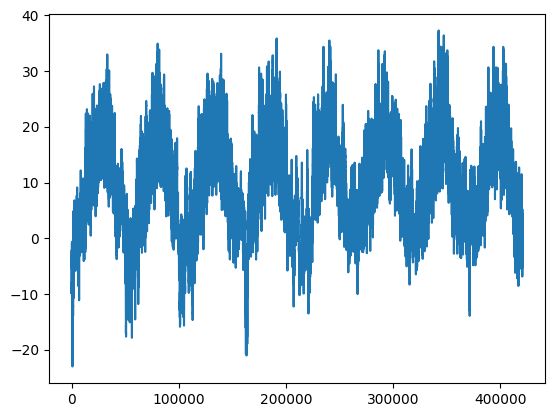

In [4]:
# Plotting the temperature data
from matplotlib import pyplot as plt 
plt.plot(range(len(temperature)), temperature)

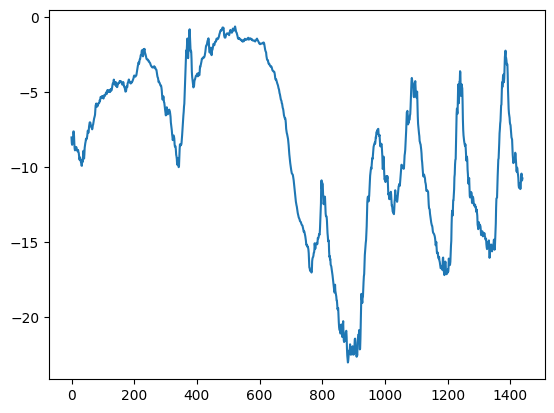

In [5]:
# Plotting the first 10 days of the temperature data
plt.plot(range(1440), temperature[:1440])
plt.show()

##### Preparing the data

We'll proprocess the data by substracting the mean of each timeseries and dividing by the standard deviation.
We're going to use the first 200,000 timesteps as training data, so we'll compute the mean and standard deviation only on this fraction of the data.

In [22]:
# Computing the number of samples we’ll use for each data split
num_train_samples = int(0.5 * len(lines))
num_val_samples = int(0.25 * len(lines))
num_test_samples = len(lines) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [23]:
# Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

##### Creating a generator

Because the samples in the dataset are highly redundant (sample N and sample N + 1 will share most of their time steps), explicitly allocating memory for each sample would be inefficient. Instead, we generate the samples on the fly, keeping only the original raw_data and temperature arrays in memory. This approach ensures that data is created dynamically, only when needed, saving memory and computational resources.

Keras provides a built-in utility, timeseries_dataset_from_array(), which simplifies the process. This function is versatile and can be used for any kind of time series forecasting task.

We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing. 

1. When making the training dataset, we’ll pass start_index = 0 and end_index = num_train_samples to only use the first 50% of the data. 
2. For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data. 
3. Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.

In [50]:
# Instantiating datasets for training, validation, and testing
import keras
from keras.utils import timeseries_dataset_from_array

sampling_rate = 6 # 1 data point per hour
sequence_length = 120 # 5 days
delay = sampling_rate * (sequence_length + 24 - 1) # 24 hours
batch_size = 256 

train_dataset = timeseries_dataset_from_array(raw_data[:-delay],
                                              targets=temperature[delay:],
                                              sampling_rate=sampling_rate, 
                                              sequence_length=sequence_length,
                                              shuffle=True,
                                              batch_size=batch_size,
                                              start_index=0,
                                              end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(raw_data[:-delay],
                                            targets=temperature[delay:],
                                            sampling_rate=sampling_rate, 
                                            sequence_length=sequence_length,
                                            batch_size=batch_size,
                                            start_index=num_train_samples,
                                            end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(raw_data[:-delay], 
                                             targets=temperature[delay:],
                                             sampling_rate=sampling_rate, 
                                             sequence_length=sequence_length,
                                             batch_size=batch_size,
                                             start_index=num_train_samples + num_val_samples)
            

Each dataset yields a tuple (samples, targets), where:
- samples is a batch of 256 samples, each containing 120 consecutive hours of input data;
- targets is the corresponding array of 256 target temperatures.

In [51]:
# Inspecting the output of one of our datasets
for samples, targets in train_dataset:
    print(samples.shape)
    print(targets.shape)
    break

(256, 120, 14)
(256,)


##### A common-sense, non machine-learning baseline

Before we start using black-box deep learning models to solve the temperature prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now. 

Here’s the evaluation loop.

In [28]:
# Computing the common-sense baseline MAE
def evaluate_naive_method(dataset): 
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

2024-09-18 23:11:04.235226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation MAE: 2.44


2024-09-18 23:11:13.743198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius.
Now the game is to use your knowledge of deep learning to do better.

##### A basic machine-learning approach

In the same way that it’s useful to establish a common-sense baseline before trying machine learning approaches, it’s useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity you throw at the problem is legitimate and delivers real benefits.
The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers.

##### Let’s try a 1D convolutional model

1D convnets are a great fit for any sequence data that follows the translation invariance assumption (meaning that if you slide a window over the sequence, the content of the window should follow the same properties independently of the location of the window).

We can build 1D convnets strictly analogous to 2D convnets.
Let’s try one on our temperature-forecasting problem. We’ll pick an initial window length of 24, so that we look at 24 hours of data at a time (one cycle).

In [66]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 87s 100ms/step - loss: 29.5629 - mae: 4.1959 - val_loss: 17.2943 - val_mae: 3.3017
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - loss: 17.7484 - mae: 3.2989 - val_loss: 20.8016 - val_mae: 3.6484
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - loss: 14.8566 - mae: 3.0502 - val_loss: 13.2072 - val_mae: 2.8787
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 78s 95ms/step - loss: 13.7780 - mae: 2.9329 - val_loss: 13.7558 - val_mae: 2.9055
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 84s 102ms/step - loss: 13.1612 - mae: 2.8674 - val_loss: 14.1690 - val_mae: 2.9528
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 75s 91ms/step - loss: 12.7264 - mae: 2.8199 - val_loss: 12.9768 - val_mae: 2.8332
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 65s 80ms/step - loss: 12.3425 - mae: 2.7763 - val_loss: 14.8856 - val_mae: 3.0478
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 61s 74ms/step - loss: 12.0677 - mae: 2.7445 - val_loss: 13.7455 - val_mae: 2.9199
Epoch 9/10
819/819 ━━━

This model doesn't perform as well as we might have thought.
What went wrong here? Two things:
1. First, weather data doesn’t quite respect the translation invariance assumption. While the data does feature daily cycles, data from a morning follows different properties than data from an evening or from the middle of the night. Weather data is only translation-invariant for a very specific timescale.
2. Second, order in our data matters—a lot. The recent past is far more informative for predicting the next day’s temperature than data from five days ago. A 1D convnet is not able to leverage this fact. In particular, our max pooling and global average pooling layers are largely destroying order information.

##### A first recurrent baseline

There’s a family of neural network architectures designed specifically for this use case: recurrent neural networks. Among them, the Long Short Term Memory (LSTM) layer has long been very popular.

In [85]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

819/819 ━━━━━━━━━━━━━━━━━━━━ 119s 140ms/step - loss: 66.4381 - mae: 6.1583 - val_loss: 11.8488 - val_mae: 2.6304
405/405 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - loss: 14.4731 - mae: 2.8806
Test MAE: 2.86


### Recurrent neural networks (RNN)

A major characteristic of all neural networks we’ve seen so far, such as densely connected networks and convnets, is that they have no memory. With such networks, in order to process a sequence or a temporal series of data points, you have to show the entire sequence to the network at once: turn it into a single data point. 
Such networks are called feedforward networks.

In contrast, as you’re reading the present sentence, you’re processing it word by word—or rather while keeping memories of what came before.
A recurrent neural network (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a state that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal loop.


To make these notions absolutely unambiguous, let’s write a naive NumPy implemen- tation of the forward pass of the simple RNN.

In [69]:
# NumPy implementation of a simple RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

That’s easy enough. In summary, an RNN is a for loop that reuses quantities computed during the previous iteration of the loop, nothing more.

##### A recurrent layer in Keras

The process we just naively implemented in NumPy corresponds to an actual Keras layer—the SimpleRNN layer.
There is one minor difference: SimpleRNN processes batches of sequences, like all other Keras layers, not a single sequence as in the NumPy example. This means it takes inputs of shape (batch_size, timesteps, input_features), rather than (timesteps, input_features).

When specifying the shape argument of the initial Input(), note that you can set the timesteps entry to None, which enables your network to process sequences of arbitrary length. This is especially useful if your model is meant to process sequences of variable length. However, if all of your sequences have the same length, I recommend specifying a complete input shape, since it enables model.summary() to display output length information, which is always nice, and it can unlock some performance optimizations.

In [70]:
# An RNN layer that can process sequences of any length
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

All recurrent layers in Keras (SimpleRNN, LSTM, and GRU) can be run in two different modes: they can 
- return either full sequences of successive outputs for each time- step (a rank-3 tensor of shape (batch_size, timesteps, output_features)) or 
- return only the last output for each input sequence (a rank-2 tensor of shape (batch_ size, output_features)). 

These two modes are controlled by the return_sequences constructor argument. Let’s look at an example that uses SimpleRNN and returns only the output at the last timestep.

In [72]:
# An RNN layer that returns only its last output step
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs) 
print(outputs.shape)

(None, 16)


In [74]:
# An RNN layer that returns its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs) 
print(outputs.shape)

(None, 120, 16)


It’s sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. In such a setup, you have to get all of the intermediate layers to return a full sequence of outputs.

In [75]:
# Stacking RNN layers
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs) 
x = layers.SimpleRNN(16, return_sequences=True)(x) 
outputs = layers.SimpleRNN(16)(x)

##### Long-Short term memory

In practice, you’ll rarely work with the SimpleRNN layer. It’s generally too simplistic to be of real use. In particular, SimpleRNN has a major issue: although it should theoretically be able to retain at time t information about inputs seen many timesteps before, such long-term dependencies prove impossible to learn in practice. This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforward networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. 

Thankfully, SimpleRNN isn’t the only recurrent layer available in Keras. There are two others, LSTM and GRU, which were designed to address these issues.

Let’s consider the LSTM layer. The underlying Long Short-Term Memory (LSTM) algorithm was developed by Hochreiter and Schmidhuber in 1997.
This layer is a variant of the SimpleRNN layer you already know about; it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you’re processing. Information from the sequence can jump onto the conveyor belt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it saves information for later, thus preventing older signals from gradually vanishing during processing. 

### Advanced use of recurrent neural networks

Next, we’ll review a number of more advanced features of RNNs; we’ll cover the following:
- Recurrent dropout -> This is a variant of dropout, used to fight overfitting in recurrent layers.
- Stacking recurrent layers —> This increases the representational power of the model (at the cost of higher computational loads).
- Bidirectional recurrent layers —> These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

We’ll use these techniques to refine our temperature-forecasting RNN.

##### Using recurrent dropout to fight overfitting

In 2016, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep. 
What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras has two dropout-related arguments: 
- dropout: A float specifying the dropout rate for the input units of the layer. For instance, if we set dropout=0.2, it means that 20% of the inputs will be ignored during each training step.
- recurrent_dropout: A float specifying the dropout rate for the recurrent units. For instance, if we set recurrent_dropout=0.2, it means that 20% of the recurrent units will be ignored during each training step.

Because networks being regularized with dropout always take much longer to fully converge, we’ll train the model for five times as many epochs.

In [79]:
# Training and evaluating a dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 169ms/step - loss: 45.1357 - mae: 4.9993 - val_loss: 9.7030 - val_mae: 2.4239
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 169ms/step - loss: 15.1077 - mae: 3.0225 - val_loss: 9.2462 - val_mae: 2.3691
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 168ms/step - loss: 14.5721 - mae: 2.9636 - val_loss: 9.1329 - val_mae: 2.3521
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 157s 191ms/step - loss: 14.0470 - mae: 2.9076 - val_loss: 9.2538 - val_mae: 2.3604
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 147s 179ms/step - loss: 13.6205 - mae: 2.8626 - val_loss: 8.9640 - val_mae: 2.3270


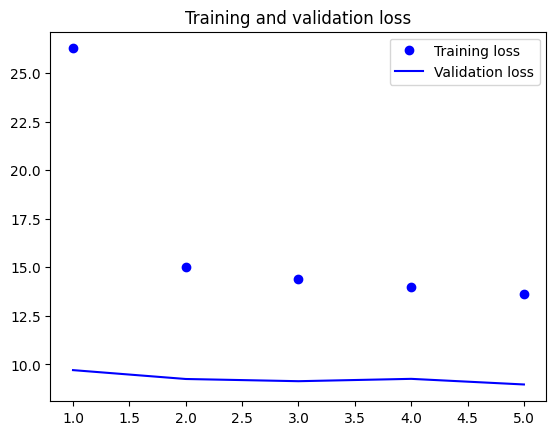

In [80]:
# Plotting the training and validation loss
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Success! We’re no longer overfitting.

##### Stacking recurrent layers

Because we’re no longer overfitting but seem to have hit a performance bottleneck, we should consider increasing the capacity and expressive power of the network. Recall the description of the universal machine learning workflow: it’s generally a good idea to increase the capacity of your model until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using drop-out). As long as you aren’t overfitting too badly, you’re likely under capacity.
Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a rank-3 tensor). As you’ve already learned, this is done by specifying return_sequences=True.

In the following example, we’ll try a stack of two dropout-regularized recurrent layers. For a change, we’ll use Gated Recurrent Unit (GRU) layers instead of LSTM. GRU is very similar to LSTM—you can think of it as a slightly simpler, streamlined version of the LSTM architecture.

In [90]:
# Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

819/819 ━━━━━━━━━━━━━━━━━━━━ 273s 315ms/step - loss: 41.7116 - mae: 4.7911 - val_loss: 9.5419 - val_mae: 2.3924
405/405 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - loss: 11.8816 - mae: 2.6394
Test MAE: 2.56


##### Using bidirectional RNNs

The last technique we’ll look at in this section is the bidirectional RNN.
A bidirectional RNN uses two regular RNNs, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merges their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

In [84]:
# Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 162ms/step - loss: 52.5862 - mae: 5.3299 - val_loss: 10.7367 - val_mae: 2.5382


The reversed-order LSTM strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of the approach. 
However, this isn’t true for many other problems, including natural language: intui- tively, the importance of a word in understanding a sentence isn’t usually dependent on its position in the sentence.